## Denoising convolutional neural network based Autoencoder


The dataset and its description can be downloaded from: https://www.kaggle.com/c/denoising-dirty-documents


Import **libraries**

In [2]:
import os
import numpy as np
import random
import pandas as pd
import cv2
from scipy import signal
from PIL import Image
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, MaxPooling2D, UpSampling2D, BatchNormalization, Flatten
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers

%matplotlib inline

### Gather data

In [3]:
# data path
train_images_path = 'denoising-dirty-documents/train'
train_cleaned_path = 'denoising-dirty-documents/train_cleaned'
test_images_path  = 'denoising-dirty-documents/test'


# sort the data
train = sorted(os.listdir(train_images_path))
train_labels = sorted(os.listdir(train_cleaned_path))
test = sorted(os.listdir(test_images_path))

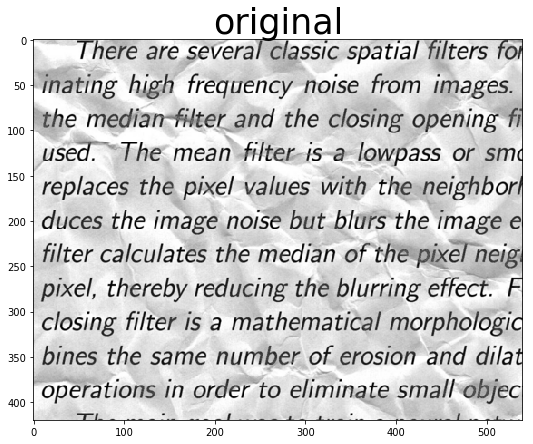

In [6]:
# import and display data
plt.figure(figsize = (15, 7))
idx = 108
img = cv2.imread('denoising-dirty-documents/train/'+ str(idx)+'.png', 0)
img2 = cv2.imread('denoising-dirty-documents/train_cleaned/'+ str(idx)+'.png', 0)
plt.imshow(img, cmap ='gray')
plt.title('original', size=35);

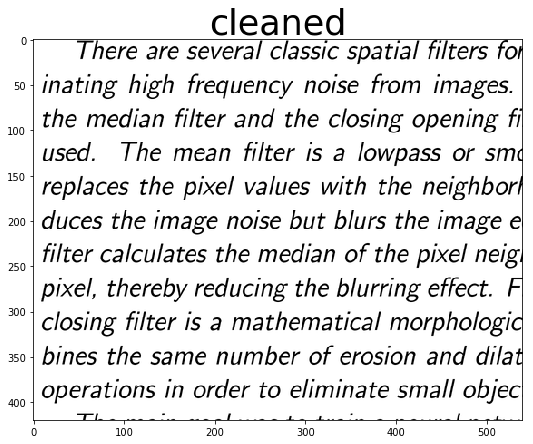

In [7]:
plt.figure(figsize = (15, 7))
plt.imshow(img2, cmap ='gray')
plt.title('cleaned', size=35);

### Data processing

In [8]:
def process_images(folder, shape = (420, 540)):
    '''
    Processing images (convert to array, normalize and create list of images (arrays))
    '''
    
    path = 'denoising-dirty-documents/{}/*.png'.format(folder)
    all_imgs = np.zeros((len(glob.glob(path)), shape[0], shape[1], 1))
    
    for idx, img_name in enumerate(glob.glob(path)):
        
        # covert to array and normalize                
        img = image.load_img(img_name, color_mode='grayscale', target_size=(shape[0], shape[1]))
        img_array = image.img_to_array(img).astype('float32')/255
        all_imgs [idx] = img_array

    return all_imgs

In [9]:
train_images = process_images('train')
print('The shape of train images (samples, height, Width, Channels):', train_images.shape)

test_images = process_images('test')
print('The shape of test_images (samples, height, Width, Channels):', test_images.shape)

train_cleaned_images = process_images('train_cleaned')
print('The shape of train_cleaned_images  (samples, height, Width, Channels):', train_cleaned_images.shape)

The shape of train images (samples, height, Width, Channels): (144, 420, 540, 1)
The shape of test_images (samples, height, Width, Channels): (72, 420, 540, 1)
The shape of train_cleaned_images  (samples, height, Width, Channels): (144, 420, 540, 1)


## Method-1 with image processing

In [10]:
# denoise with signal processing
def denoise_image(img_arr):
    '''
     Denoise the image by highliting the foregroud
     Mask the foreground from the background. 
     Idea from Ragel Dakov, https://www.kaggle.com/rdokov/background-removal
    '''
    # estimate 'background' color by a median filter
    background = signal.medfilt2d(img_arr, 11)

    # compute 'foreground' mask as anything that is significantly darker than the background
    mask = img_arr < (background-0.1)

    # return the input value for all pixels in the mask or pure white otherwise
    return np.where(mask, img_arr, 1.0)

In [11]:
# implementation on train data
path = 'denoising-dirty-documents/train/*.png' 
shape = (420, 540)
all_imgs = np.zeros((len(glob.glob(path)), shape[0], shape[1], 1))

for idx, img_name in enumerate(glob.glob(path)):

    # covert to array and normalize                
    img = image.load_img(img_name, color_mode='grayscale')
    img_array = image.img_to_array(img).astype('float32')/255
    img_array.resize((shape[0],shape[1]))

    # denoise the image
    filtered_img = denoise_image(img_array)
    filtered_img.resize((shape[0],shape[1], 1))
    all_imgs [idx] = filtered_img

In [12]:
# visulaize output
idx = 23

d_sample = all_imgs[idx] * 255.0
d_sample = d_sample.reshape(shape[0], shape[1])

train_sample = train_images[idx] * 255.0
train_sample = train_sample.reshape(shape[0], shape[1])

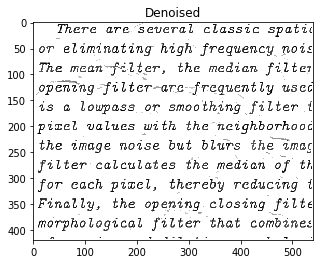

In [13]:
plt.imshow(d_sample, cmap='gray')
plt.title('Denoised');

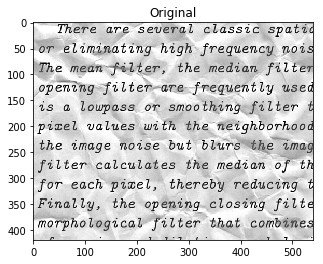

In [14]:
plt.imshow(train_sample, cmap='gray')
plt.title('Original');

## Method-2 with Autoencoders

In [15]:
# split the train data into train and valid sets
X_train, X_valid, y_train, y_valid = train_test_split(train_images, train_cleaned_images, test_size = 0.15, random_state = 23)
print("There are {} samples in Train and {} samples in Valid".format(X_train.shape[0], X_valid.shape[0]))

There are 122 samples in Train and 22 samples in Valid


In [16]:
# create test samples for comparison
path = 'denoising-dirty-documents/test/*.png'
test_original = np.zeros((len(glob.glob(path)), shape[0], shape[1], 1))
shape = (420, 540)
for idx, img_name in enumerate(glob.glob(path)):
    img = image.load_img(img_name, color_mode='grayscale', target_size=(shape[0], shape[1]))
    img_array = image.img_to_array(img).astype('float32')/255
    test_original[idx] = img_array


### Model

In [20]:
class CNN_Autoencoder():
    '''
    CNN Autoencoder with encoder and decoder
    '''
    def __init__(self):
        self.rows = 420
        self.columns = 540
        self.channels = 1 
        self.inputs = Input(shape= (self.rows, self.columns, self.channels))
        
    def conv_layer(self, filters, kernel_size, activation = 'relu', pad = 'same'):
        x = Conv2D(filters, kernel_size, activation= activation, padding= pad, activity_regularizer=regularizers.l1(0.001))
        return x       
        
    def encoder(self):

        x = self.conv_layer(64, 3)(self.inputs)
        x = MaxPooling2D((2, 2), padding='same')(x)
        # x = Dropout(0.3)(x)
        x = self.conv_layer(32, 3)(x)
        encoded = MaxPooling2D((2, 2), padding='same')(x)
        return encoded
    
    def decoder(self):
        encoded = self.encoder()
        
        x = self.conv_layer(32, 3)(encoded)
        x = UpSampling2D((2, 2))(x)
        # x = Dropout(0.3)(x)
        x = self.conv_layer(64, 3)(x)
        x =  UpSampling2D((2, 2))(x)
        decoded = self.conv_layer(1, 3, activation='sigmoid')(x)
        return decoded
    
    def model(self):
        return Model(self.inputs, self.decoder())

In [21]:
cnn_ae = CNN_Autoencoder()
model = cnn_ae.model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 420, 540, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 420, 540, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 210, 270, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 210, 270, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 105, 135, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 105, 135, 32)      9248      
_________________________________________________________________
up_s

In [22]:
## compile
# optimizer
# opt = tensorflow.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer= 'adam', loss='binary_crossentropy')

#callbacks
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='min', restore_best_weights=True)

### Train the model

In [ ]:
epochs = 100
batch_size = 32

history = model.fit(X_train,
                y_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_valid, y_valid),
                callbacks = [es]
               )

Train on 122 samples, validate on 22 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100


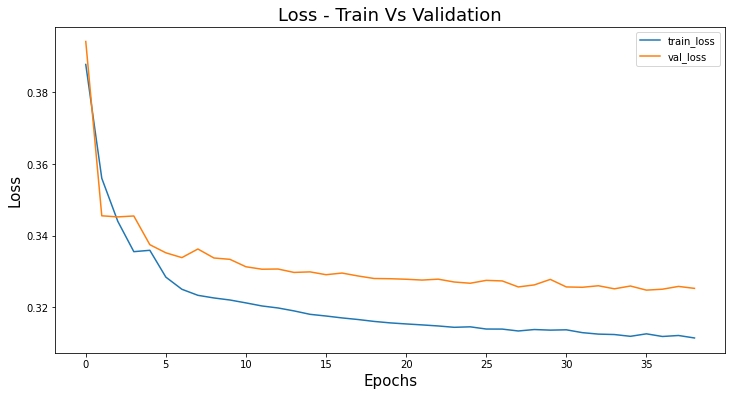

In [32]:
# Trainig details
plt.figure(figsize=(12,6))


plt.plot(history.epoch, history.history['loss'], label = "train_loss") 
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") 

plt.title("Loss - Train Vs Validation",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.legend()
# plt.savefig("Loss_curve.png")
plt.show()

### Prediction part

In [33]:
# prediction on test data
preds = model.predict(test_images)
print(preds.shape)

(72, 420, 540, 1)


In [34]:
# Prediction
idx = 40
preds_sample = preds[idx] * 255.0
preds_sample = preds_sample.reshape(shape[0], shape[1])
x_test = test_original[idx] * 255.0
x_test = x_test.reshape(shape[0], shape[1])

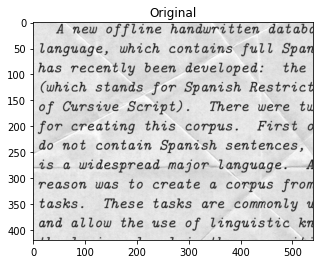

In [28]:
plt.imshow(x_test, cmap='gray')
plt.title('Original');

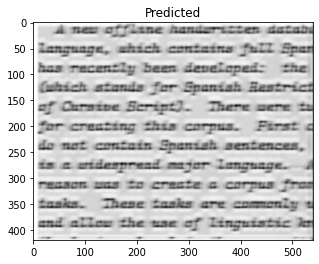

In [35]:
plt.imshow(preds_sample, cmap='gray')
plt.title('Predicted');

In [ ]:
# Submission to kaggle
Path_original = glob.glob('denoising-dirty-documents/test/*.png')
ids = []
vals = []
for i, f in enumerate(Path_original):
    file = os.path.basename(f)
    imgid = int(file[:-4])
    test_img = cv2.imread(f, 0)
    img_shape = test_img.shape
    preds_reshaped = cv2.resize(preds[i], (img_shape[1], img_shape[0]))
    for r in range(img_shape[0]):
        for c in range(img_shape[1]):
            ids.append(str(imgid)+'_'+str(r + 1)+'_'+str(c + 1))
            vals.append(preds_reshaped[r, c])

pd.DataFrame({'id': ids, 'value': vals}).to_csv('submission.csv', index=False)

In [ ]:
len(vals)

14230080

 no. of rows required for submission is satisfied

 ## Autoencoder method can be improved by working on image processing techniques, architecture improvement (more deeper), hyperparameter tuning